## Load libraries

In [1]:
import os
import logging

import numpy as np
from sklearn.metrics import accuracy_score, classification_report
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

from alphai_watson.performance import GANPerformanceAnalysis
from alphai_watson.transformer import NullTransformer
from alphai_rickandmorty_oracle.datasource.brainwaves import BrainwavesDataSource
from alphai_rickandmorty_oracle.detective import RickAndMortyDetective
from alphai_rickandmorty_oracle.model import RickAndMorty

from alphai_rickandmorty_oracle.architecture.brainwaves import BrainwavesGanArchitecture

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

%matplotlib inline


/home/gmariotti/miniconda3/envs/rickmorty/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
DEBUG:matplotlib.pyplot:Loaded backend agg version unknown.


Uppercase local vars:
	BATCH_SIZE: 50
	CRITIC_ITERS: 5
	DEFAULT_FIT_EPOCHS: 1000
	DEFAULT_LEARN_RATE: 0.0001
	DEFAULT_TRAIN_ITERS: 5000
	DEFAULT_Z_DIM: 200
	DIAGNOSIS_LEARN_RATE: 0.01
Enabling weight norm


## Define KDDCup99 Datasource

In [2]:
n_sensors = 16
n_timesteps = 784 // n_sensors
file_path = '../../tests/resources'

train_data_file = os.path.join(file_path, 'brainwaves_normal_sample_1.hd5')
test_data_file = os.path.join(file_path, 'brainwaves_normal_and_abnormal.hd5')

train_data_source = BrainwavesDataSource(
    source_file=train_data_file,
    transformer=NullTransformer(number_of_timesteps=n_timesteps, number_of_sensors=n_sensors)
)

test_data_source = BrainwavesDataSource(
    source_file=test_data_file,
    transformer=NullTransformer(number_of_timesteps=n_timesteps, number_of_sensors=n_sensors)
)

train_data = train_data_source.get_train_data('NORMAL')

test_normal_samples = test_data_source.get_train_data('NORMAL')
test_abnormal_samples = test_data_source.get_train_data('ABNORMAL')

## Define Model

In [3]:
model_dir = './brainwaves_models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

output_dimensions = 784
plot_dimensions = (28, 28)
batch_size = 64
train_iters = 10000
z_dim = 128
plot_save_path = model_dir

architecture = BrainwavesGanArchitecture(output_dimensions, plot_dimensions)

model = RickAndMorty(architecture=architecture,
                     batch_size=batch_size,
                     train_iters=train_iters,
                     z_dim=z_dim,
                     plot_save_path=plot_save_path,
                     use_consistency_cost=True)

detective = RickAndMortyDetective(model_configuration={
    'model': model,
    'batch_size': model.batch_size,
    'output_dimensions': model.architecture.output_dimensions,
    'train_iters': model.train_iters,
    'plot_save_path': plot_save_path
})

### Train

iter 0	train disc cost	2366.755126953125	time	0.844301700592041
iter 1	train gen cost	0.12298282980918884	train disc cost	3472.348876953125	time	0.23992085456848145
iter 2	train gen cost	0.06387840211391449	train disc cost	3028.513916015625	time	0.1539156436920166
iter 3	train gen cost	0.07898863404989243	train disc cost	4383.8828125	time	0.1516721248626709
iter 4	train gen cost	0.13599899411201477	train disc cost	2175.469970703125	time	0.151458740234375
iter 99	train gen cost	-0.31941595673561096	train disc cost	537.2479248046875	time	0.15484500182302374
iter 199	train gen cost	-0.7340249419212341	train disc cost	17.601530075073242	time	0.1543356418609619
iter 299	train gen cost	-1.5457665920257568	train disc cost	-18.372299194335938	time	0.15656426191329956
iter 399	train gen cost	-1.5266389846801758	train disc cost	-32.906150817871094	time	0.15645373344421387
iter 499	train gen cost	67.8414077758789	train disc cost	-89.3703384399414	time	0.15438894748687745
iter 599	train gen cost	1

iter 7699	train gen cost	2128.06494140625	train disc cost	-1579.6494140625	time	0.15555442333221436
iter 7799	train gen cost	2138.615478515625	train disc cost	-1568.4183349609375	time	0.15862375020980835
iter 7899	train gen cost	2128.72265625	train disc cost	-1574.7637939453125	time	0.15750956058502197
iter 7999	train gen cost	2122.916748046875	train disc cost	-1556.19482421875	time	0.15671451807022094
iter 8099	train gen cost	2130.755615234375	train disc cost	-1564.94921875	time	0.1593441677093506
iter 8199	train gen cost	2128.747802734375	train disc cost	-1558.9542236328125	time	0.15867818593978883
iter 8299	train gen cost	2139.354248046875	train disc cost	-1605.2572021484375	time	0.15369871377944946
iter 8399	train gen cost	2140.006103515625	train disc cost	-1529.44384765625	time	0.1589603281021118
iter 8499	train gen cost	2131.789306640625	train disc cost	-1585.5228271484375	time	0.1624462366104126
iter 8599	train gen cost	2131.5654296875	train disc cost	-1593.26123046875	time	0.15

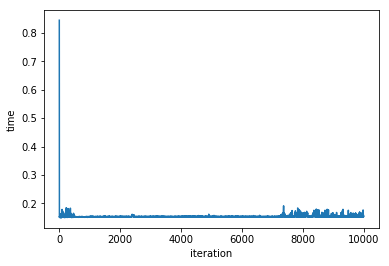

In [4]:
detective.train(train_data);

### Plot cost curves

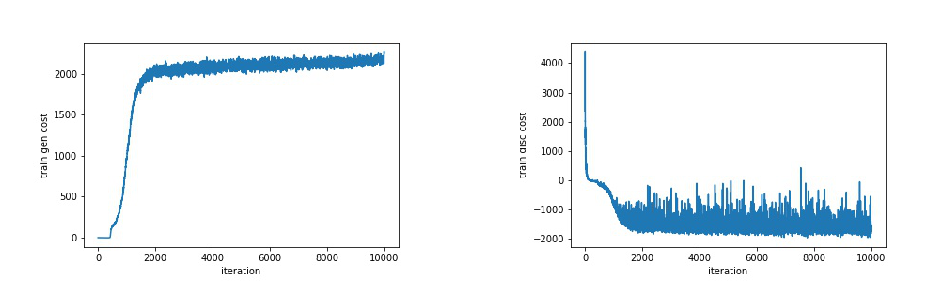

In [5]:
gen_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_gen_cost.jpg'))
disc_cost_img = mpimg.imread(os.path.join(plot_save_path, 'train_disc_cost.jpg'))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
ax1.imshow(gen_cost_img);
ax1.axis('off');
ax2.imshow(disc_cost_img);
ax2.axis('off');

## Evaluate results
***

### Visualise generated samples

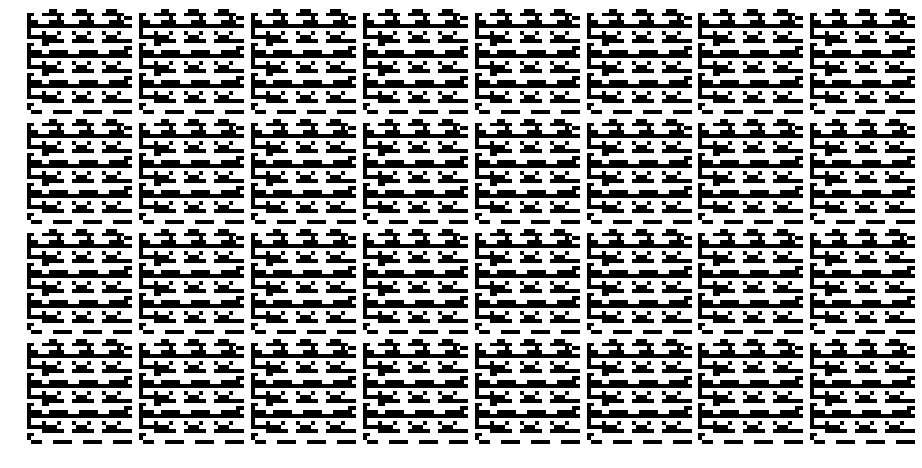

In [6]:
n_row = 4
n_col = 8

plt.figure(figsize=(2*n_col, 2*n_row))

gs = gridspec.GridSpec(n_row, n_col)
gs.update(wspace=0.025, hspace=0.05)

generated_samples = detective.model.generate_fake_samples()

for i in range(n_row * n_col):
    ax = plt.subplot(gs[i])
    ax.axis('off')
    ax.imshow(generated_samples[i], cmap='gray')

### Collate ground truth and detection results

In [7]:
n1 = np.ones(len(test_normal_samples.data))
n2 = np.zeros(len(test_abnormal_samples.data))

expected_truth = np.hstack((n1, n2))

test_results_normal = detective.detect(test_normal_samples).data
test_results_abnormal = detective.detect(test_abnormal_samples).data
detection_result = np.hstack((test_results_normal, test_results_abnormal))

### Calculate ROC Score

In [8]:
roc_score = GANPerformanceAnalysis({}).analyse(
    detection_result=detection_result.data,
    expected_truth=expected_truth
)
print('ROC Score: {}'.format(roc_score))

ROC Score: 0.6961370633832564


### Generate classification report

In [9]:
train_results = detective.detect(train_data).data
threshold = np.mean(train_results)
prediction = [1 if x >= threshold else 0 for x in detection_result.data]

target_names = ['ABNORMAL', 'NORMAL']
print(classification_report(expected_truth, prediction, target_names=target_names))

              precision    recall  f1-score   support

    ABNORMAL       0.62      0.76      0.68      4893
      NORMAL       0.69      0.52      0.60      4893

   micro avg       0.64      0.64      0.64      9786
   macro avg       0.65      0.64      0.64      9786
weighted avg       0.65      0.64      0.64      9786



## Root Cause Analysis

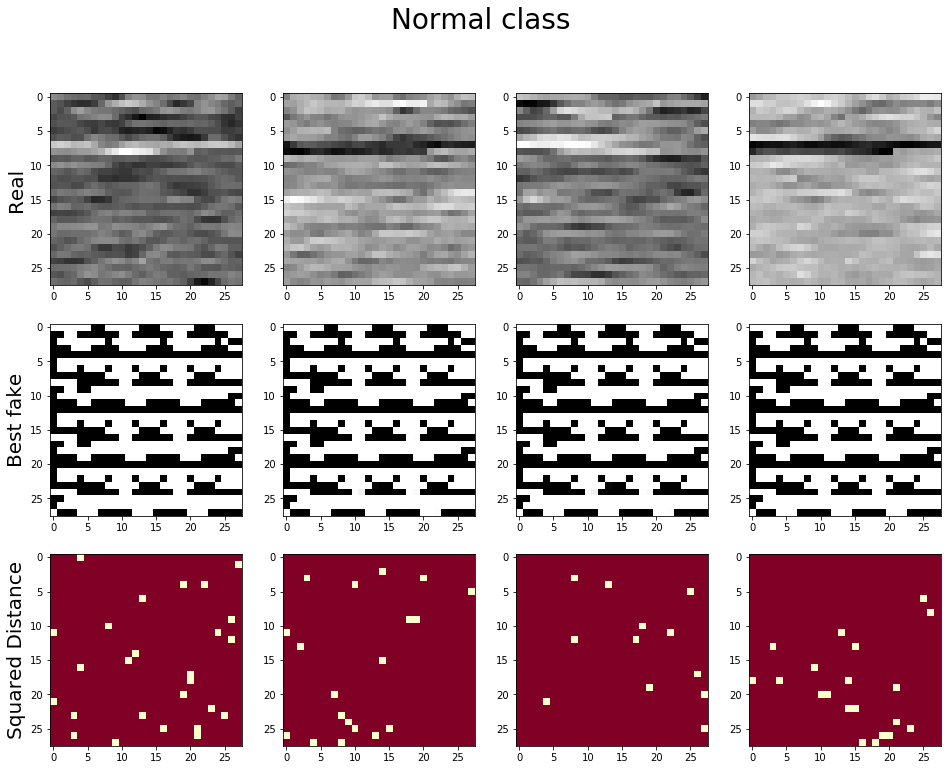

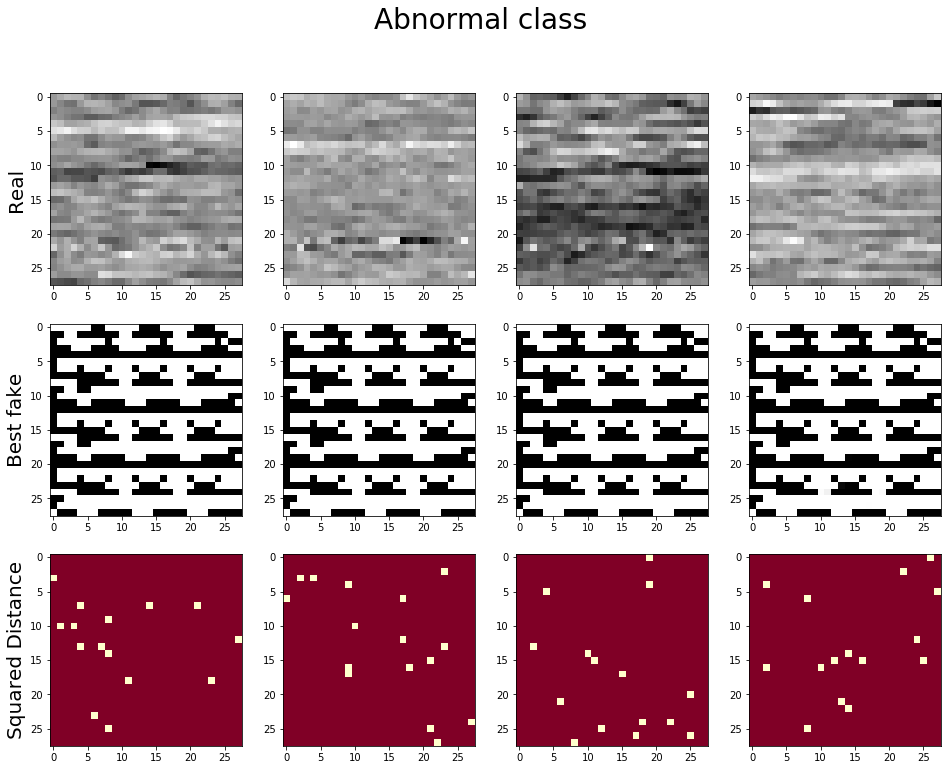

In [10]:
n_img = 4

normal_test_samples = \
    test_normal_samples.data[np.random.choice(test_normal_samples.data.shape[0], n_img, replace=False), :]
abnormal_test_samples = \
    test_abnormal_samples.data[np.random.choice(test_abnormal_samples.data.shape[0], n_img, replace=False), :]

normal_best_fakes = [detective.diagnose(nor_img) for nor_img in normal_test_samples]
abnormal_best_fakes = [detective.diagnose(abn_img) for abn_img in abnormal_test_samples]

# Plot normal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Normal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(np.reshape(normal_test_samples[i], (28, 28)), cmap='gray'); 
    ax[1, i].imshow(np.reshape(normal_best_fakes[i], (28, 28)), cmap='gray')
    ax[2, i].imshow(np.reshape(np.square(normal_test_samples[i] - normal_best_fakes[i]), (28, 28)), 
                    cmap='YlOrRd', vmin=0, vmax=1)

# Plot abnormal class
fig, ax = plt.subplots(3, n_img, figsize=(16, 12))
fig.suptitle('Abnormal class', fontsize=28)
ax[0, 0].set_ylabel('Real', fontsize=20)
ax[1, 0].set_ylabel('Best fake', fontsize=20)
ax[2, 0].set_ylabel('Squared Distance', fontsize=20)

for i in range(n_img):
    ax[0, i].imshow(np.reshape(abnormal_test_samples[i], (28, 28)), cmap='gray'); 
    ax[1, i].imshow(np.reshape(abnormal_best_fakes[i], (28, 28)), cmap='gray')
    ax[2, i].imshow(np.reshape(np.square(abnormal_test_samples[i] - abnormal_best_fakes[i]), (28, 28)), 
                    cmap='YlOrRd', vmin=0, vmax=1)